In [32]:
from dotenv import load_dotenv

load_dotenv()

True

In [33]:
from typing import TypedDict, Literal, Annotated, List
from operator import add
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

class InputState(TypedDict):
    article: str

class OutputState(TypedDict):
    agent_output: str

class OverallState(InputState, OutputState):
    messages: Annotated[List[BaseMessage], add]

@tool
def get_current_club(player_name: str):
    """Gets current club of a player"""
    fake_db = {
        "Lionel Messi": "Paris Saint-Germain",
        "Cristiano Ronaldo": "Al Nassr FC",
    }
    return fake_db.get(player_name, "Current club information not available.")

tools2 = [get_current_club]
model2 = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools2)

def call_model_current_club(state: OverallState):
    local_messages = state.get('messages', [])
    if not local_messages:
        human_message = HumanMessage(content=state['article'])
        local_messages.append(human_message)
    system_message = SystemMessage(content="""You are an agent tasked with determining the current club of a player.
If the current club is mentioned, return it. Otherwise, return 'Current club information not available.'""")
    response = model2.invoke([system_message] + local_messages)
    state['agent_output'] = response.content
    state['messages'] = local_messages + [response]
    return state

def should_continue(state: OverallState) -> Literal["tools", END]:
    last_message = state['messages'][-1]
    if getattr(last_message, 'tool_calls', None):
        return "tools"
    return END

current_club_graph = StateGraph(OverallState, input=InputState, output=OutputState)
current_club_graph.add_node("call_model_current_club", call_model_current_club)
current_club_graph.add_node("tools", ToolNode(tools2))
current_club_graph.add_edge(START, "call_model_current_club")
current_club_graph.add_conditional_edges("call_model_current_club", should_continue)
current_club_graph.add_edge("tools", "call_model_current_club")

current_club_researcher_agent = current_club_graph.compile()


In [34]:
initial_state = {
    "article": "Lionel Messi will join Real Madrid 2025",
}
current_club_researcher_agent.invoke(initial_state)

{'agent_output': "Lionel Messi's current club is Paris Saint-Germain."}

In [35]:
class InputState(TypedDict):
    article: str

class OutputState(TypedDict):
    agent_output: str

class OverallState(InputState, OutputState):
    messages: Annotated[List[BaseMessage], add]

@tool
def get_market_value(player_name: str):
    """Gets current market value of a player"""
    fake_market_value_db = {
        "Lionel Messi": "€50 million",
        "Cristiano Ronaldo": "€30 million",
    }
    return fake_market_value_db.get(player_name, "Market value information not available.")

tools2 = [get_market_value]
model2 = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools2)

def call_model_market_value(state: OverallState):
    local_messages = state.get('messages', [])
    if not local_messages:
        human_message = HumanMessage(content=state['article'])
        local_messages.append(human_message)
    system_message = SystemMessage(content="""You are an agent tasked with determining the market value of a player.
If the market value is mentioned, return it. Otherwise, return 'Market value information not available.'""")
    response = model2.invoke([system_message] + local_messages)
    state['agent_output'] = response.content
    state['messages'] = local_messages + [response]
    return state

def should_continue(state: OverallState) -> Literal["tools", END]:
    last_message = state['messages'][-1]
    if getattr(last_message, 'tool_calls', None):
        return "tools"
    return END

market_value_graph = StateGraph(OverallState, input=InputState, output=OutputState)
market_value_graph.add_node("call_model_market_value", call_model_market_value)
market_value_graph.add_node("tools", ToolNode(tools2))
market_value_graph.add_edge(START, "call_model_market_value")
market_value_graph.add_conditional_edges("call_model_market_value", should_continue)
market_value_graph.add_edge("tools", "call_model_market_value")

market_value_researcher_agent = market_value_graph.compile()

In [36]:
market_value_researcher_agent.invoke({"article": "Lionel Messi will switch from FC Barcelona to Real Madrid in 2025"})

{'agent_output': 'The market value of Lionel Messi is €50 million.'}

In [37]:
class InputState(TypedDict):
    article: str

class OutputState(TypedDict):
    agent_output: str

class OverallState(InputState, OutputState):
    pass

model_text_writer = ChatOpenAI(model="gpt-4o-mini")

def expand_text_to_100_words(state: OverallState):
    human_message = HumanMessage(content=state['article'])
    system_message = SystemMessage(content="Expand the following text to be at least 100 words. Maintain the original meaning while adding detail.")
    response = model_text_writer.invoke([system_message, human_message])
    state['agent_output'] = response.content
    return state

text_writer_graph = StateGraph(OverallState, input=InputState, output=OutputState)
text_writer_graph.add_node("expand_text_to_100_words", expand_text_to_100_words)
text_writer_graph.add_edge(START, "expand_text_to_100_words")
text_writer_graph.add_edge("expand_text_to_100_words", END)

text_writer_agent = text_writer_graph.compile()

In [38]:
text_writer_agent.invoke({"article": "Lionel Messi will switch from FC Barcelona to Real Madrid in 2025"})

{'agent_output': "Lionel Messi, the renowned Argentine footballer, is set to make a significant transition in his illustrious career by switching from FC Barcelona to their fierce rivals, Real Madrid, in the year 2025. This move comes after a long and storied tenure at Barcelona, where Messi has become a living legend, breaking numerous records and winning countless titles, including multiple Ballon d'Or awards. The decision to join Real Madrid, a club with its own rich history and a fierce competitive spirit, is expected to send shockwaves through the footballing world. Fans and analysts alike will be watching closely to see how this bold move unfolds and what impact it will have on both clubs, as well as on Messi's legacy as one of the greatest players in the history of the sport. The anticipation surrounding this transfer will undoubtedly grow as the date approaches, making it one of the most talked-about events in football."}

### Supervisor Agent

In [39]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

class ArticlePostabilityGrader(BaseModel):
    """Binary scores for verifying if an article mentions market value, current club, and meets the minimum word count of 100 words."""

    off_or_ontopic: str = Field(
        description="The Article is about football transfers, 'yes' or 'no'"
    )
    mentions_market_value: str = Field(
        description="The article mentions the player's market value, 'yes' or 'no'"
    )
    mentions_current_club: str = Field(
        description="The article mentions the player's current club, 'yes' or 'no'"
    )
    meets_100_words: str = Field(
        description="The article has at least 100 words, 'yes' or 'no'"
    )

llm_postability = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_postability_grader = llm_postability.with_structured_output(
    ArticlePostabilityGrader
)

postability_system = """
You are a grader assessing whether a news article meets the following criteria:
1. The article is about football transfers or not. If yes answer, answer with 'yes', anotherwise with 'no'.
1. The article explicitly mentions the player's market value, for example, by stating "market value" or a specific currency amount (e.g., "$50 million"). If this is present, respond with 'yes' for mentions_market_value; otherwise, respond 'no'.
2. The article mentions the player's current club or indicates that the current club information is unavailable (e.g., "Current club information not available"). If this is present, respond with 'yes' for mentions_current_club; otherwise, respond 'no'.
3. The article contains at least 100 words. If this is met, respond with 'yes' for meets_100_words; otherwise, respond 'no'.

Provide four binary scores ('yes' or 'no') as follows:
- off_or_ontopic: 'yes' or 'no' depending on whether the article is related to football transfers or not.
- mentions_market_value: 'yes' or 'no' depending on whether the article mentions the player's market value.
- mentions_current_club: 'yes' or 'no' depending on whether the article mentions the player's current club or states that the information is unavailable.
- meets_100_words: 'yes' or 'no' depending on whether the article has at least 100 words.
"""

postability_grade_prompt = ChatPromptTemplate.from_messages(
    [("system", postability_system), ("human", "News Article:\n\n{article}")]
)

news_chef = postability_grade_prompt | structured_llm_postability_grader


In [40]:
news_chef.invoke({"article": "Lionel Messi will switch to Real Madrid in 2025"})

ArticlePostabilityGrader(off_or_ontopic='yes', mentions_market_value='no', mentions_current_club='no', meets_100_words='no')

In [41]:
news_chef.invoke({"article": "Today in Munich will be 9°C"})

ArticlePostabilityGrader(off_or_ontopic='no', mentions_market_value='no', mentions_current_club='no', meets_100_words='no')

### Workflow

In [42]:
from typing import TypedDict, Literal
from langgraph.graph import END, StateGraph

class InputArticleState(TypedDict):
    article: str

class OutputFinalArticleState(TypedDict):
    final_article: str
    off_or_ontopic: str

class SharedArticleState(InputArticleState, OutputFinalArticleState):
    mentions_market_value: str
    mentions_current_club: str
    meets_100_words: str

def update_article_state(state: SharedArticleState) -> SharedArticleState:
    response = news_chef.invoke({"article": state["article"]})
    state["off_or_ontopic"] = response.off_or_ontopic
    state["mentions_market_value"] = response.mentions_market_value
    state["mentions_current_club"] = response.mentions_current_club
    state["meets_100_words"] = response.meets_100_words
    print("State after update_article_state:", state)
    return state

def market_value_researcher_node(state: SharedArticleState) -> SharedArticleState:
    response = market_value_researcher_agent.invoke({"article": state["article"]})
    state["article"] += f" {response['agent_output']}"
    return state

def current_club_researcher_node(state: SharedArticleState) -> SharedArticleState:
    response = current_club_researcher_agent.invoke({"article": state["article"]})
    state["article"] += f" {response['agent_output']}"
    return state

def word_count_rewriter_node(state: SharedArticleState) -> SharedArticleState:
    response = text_writer_agent.invoke({"article": state["article"]})
    state["article"] += f" {response['agent_output']}"
    state["final_article"] = response["agent_output"]
    return state

def news_chef_decider(state: SharedArticleState) -> Literal["market_value_researcher", "current_club_researcher", "word_count_rewriter", END]:
    if state["off_or_ontopic"] == "no":
        return END
    if state["mentions_market_value"] == "no":
        return "market_value_researcher"
    elif state["mentions_current_club"] == "no":
        return "current_club_researcher"
    elif state["meets_100_words"] == "no" and state["mentions_market_value"] == "yes" and state["mentions_current_club"] == "yes":
        return "word_count_rewriter"
    else:
        return END

workflow = StateGraph(SharedArticleState, input=InputArticleState, output=OutputFinalArticleState)

workflow.add_node("news_chef", update_article_state)
workflow.add_node("market_value_researcher", market_value_researcher_node)
workflow.add_node("current_club_researcher", current_club_researcher_node)
workflow.add_node("word_count_rewriter", word_count_rewriter_node)

workflow.set_entry_point("news_chef")

workflow.add_conditional_edges(
    "news_chef",
    news_chef_decider,
    {
        "market_value_researcher": "market_value_researcher",
        "current_club_researcher": "current_club_researcher",
        "word_count_rewriter": "word_count_rewriter",
        END: END
    },
)

workflow.add_edge("market_value_researcher", "news_chef")
workflow.add_edge("current_club_researcher", "news_chef")
workflow.add_edge("word_count_rewriter", "news_chef")

app = workflow.compile()

In [43]:
app.invoke({"article": "Today in Munich will be 9°C"})

State after update_article_state: {'article': 'Today in Munich will be 9°C', 'off_or_ontopic': 'no', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}


{'off_or_ontopic': 'no'}

In [44]:
app.invoke({"article": "Lionel Messi will to Real Madrid in 2025"})

State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025', 'off_or_ontopic': 'yes', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million.', 'off_or_ontopic': 'yes', 'mentions_market_value': 'yes', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million. Current club information not available.', 'off_or_ontopic': 'yes', 'mentions_market_value': 'yes', 'mentions_current_club': 'yes', 'meets_100_words': 'no'}
State after update_article_state: {'article': "Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million. Current club information not available. Lionel Messi, the legendary Argentine footballer, is expected to make a sign

{'final_article': "Lionel Messi, the legendary Argentine footballer, is expected to make a significant move to Real Madrid in the year 2025. This anticipated transfer has generated considerable buzz in the football world, given Messi's illustrious career and his previous ties with Barcelona, Real Madrid's historic rival. As of now, Messi's market value stands at an impressive €50 million, reflecting his continued prowess and skill on the pitch, even as he approaches the later stages of his career. However, specific information regarding his current club situation is not available, leaving fans and analysts alike speculating about his next steps. This potential transfer could reshape the dynamics of La Liga and further establish Messi's legacy in the annals of football history.",
 'off_or_ontopic': 'yes'}

### Add Human in the Loop

In [45]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()


class InputState(TypedDict):
    question: str

class IntermediateState(InputState):
    off_or_ontopic: str
    answer: str

class FinalState(IntermediateState):
    api_response: str
    status_code: int

In [46]:
def input_node(state: InputState) -> InputState:
    return state

def newsagent_node(state: IntermediateState) -> IntermediateState:
    response = app.invoke({"article": state["question"]})
    state["answer"] = response.get("final_article", "Article not relevant for news agency")
    state["off_or_ontopic"] = response["off_or_ontopic"]
    return state

def api_call_node(state: FinalState) -> FinalState:
    state["status_code"] = 200
    state["api_response"] = f"API received answer: {state['answer']}"
    return state

In [47]:
workflow = StateGraph(FinalState, input=InputState, output=FinalState)

workflow.add_node("newsagent_node", newsagent_node)
workflow.add_node("api_call_node", api_call_node)

workflow.set_entry_point("newsagent_node")

workflow.add_edge("newsagent_node", "api_call_node")
workflow.add_edge("api_call_node", END)

In [48]:
human_app = workflow.compile(checkpointer=checkpointer, interrupt_after=["newsagent_node"])

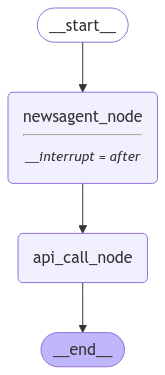

In [49]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        human_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [50]:
config = {"configurable": {"thread_id": "1"}}
config2 = {"configurable": {"thread_id": "2"}}

In [51]:
human_app.invoke({"question": "The weather will be 9°C in Munich"}, config=config2, subgraphs=True)

State after update_article_state: {'article': 'The weather will be 9°C in Munich', 'off_or_ontopic': 'no', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}


((),
 {'question': 'The weather will be 9°C in Munich',
  'off_or_ontopic': 'no',
  'answer': 'Article not relevant for news agency'})

In [52]:
human_app.invoke({"question": "Lionel Messi will to Real Madrid in 2025"}, config=config, subgraphs=True)

State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025', 'off_or_ontopic': 'yes', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million.', 'off_or_ontopic': 'yes', 'mentions_market_value': 'yes', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million. Current club information not available.', 'off_or_ontopic': 'yes', 'mentions_market_value': 'yes', 'mentions_current_club': 'yes', 'meets_100_words': 'no'}
State after update_article_state: {'article': "Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million. Current club information not available. Lionel Messi, the Argentine football superstar, is projected to make a move 

((),
 {'question': 'Lionel Messi will to Real Madrid in 2025',
  'off_or_ontopic': 'yes',
  'answer': "Lionel Messi, the Argentine football superstar, is projected to make a move to Real Madrid in the year 2025. This anticipated transfer has generated significant excitement and speculation among fans and football analysts alike. As of now, Messi's market value is estimated to be around €50 million, reflecting his immense talent and influence on the pitch, despite his age. His current club information is not available, which adds an element of mystery to his future. Many are curious to see how this potential transfer will impact both Messi's career and Real Madrid's performance in domestic and international competitions. The football world is abuzz with discussions about what this move could mean for the legendary player's legacy."})

In [53]:
snapshot = human_app.get_state(config2)
snapshot.next

('api_call_node',)

In [54]:
human_app.invoke(None, config=config2)

{'question': 'The weather will be 9°C in Munich',
 'off_or_ontopic': 'no',
 'answer': 'Article not relevant for news agency',
 'api_response': 'API received answer: Article not relevant for news agency',
 'status_code': 200}

In [55]:
snapshot = human_app.get_state(config)
snapshot.next

('api_call_node',)

In [56]:
snapshot = human_app.get_state(config)
existing_message = snapshot.values
existing_message


{'question': 'Lionel Messi will to Real Madrid in 2025',
 'off_or_ontopic': 'yes',
 'answer': "Lionel Messi, the Argentine football superstar, is projected to make a move to Real Madrid in the year 2025. This anticipated transfer has generated significant excitement and speculation among fans and football analysts alike. As of now, Messi's market value is estimated to be around €50 million, reflecting his immense talent and influence on the pitch, despite his age. His current club information is not available, which adds an element of mystery to his future. Many are curious to see how this potential transfer will impact both Messi's career and Real Madrid's performance in domestic and international competitions. The football world is abuzz with discussions about what this move could mean for the legendary player's legacy."}

In [57]:
snapshot = human_app.get_state(config)
existing_message = snapshot.values
existing_message

human_app.update_state(
    config,
    {"answer": "Fake news!!!"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efaa53f-9789-68b6-8002-a98a354cb554'}}

In [58]:
human_app.invoke(None, config=config)

{'question': 'Lionel Messi will to Real Madrid in 2025',
 'off_or_ontopic': 'yes',
 'answer': 'Fake news!!!',
 'api_response': 'API received answer: Fake news!!!',
 'status_code': 200}

In [59]:
snapshot = human_app.get_state(config)
snapshot.next

()